# Predicting Housing Prices Using Regression

The goal of this notebook is to explore multiple regression and feature engineering Sklearn functions.

In this notebook you will use data on house sales in California to predict prices using multiple, polynomial, ridge, and lasson regression. You will:
* Perform feature engineering
* Remove outliers
* Handling Text and Categorical Attributes
* Train multiple regression models 
* Inspect coefficients and interpret their meanings
* Evaluate multiple models via RMSE, MAE, and R2
* Use Cross validation to regularize weights to shrink coefficients of features not useful for predicting housing prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Import in house data

In [2]:
df = pd.read_csv('./datasets/housing_paml.csv')

In [3]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20634.000000,20622.000000,20628.000000,20633.000000,20412.000000,20623.000000,20632.000000,20628.000000,20636.000000
mean,-119.568930,35.629984,28.627400,2636.036640,537.973104,1425.785822,499.615161,3.871190,206857.824239
std,2.003309,2.135938,12.578766,2181.812336,421.485694,1132.484600,382.380686,1.899747,115403.235750
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.797500,33.930000,18.000000,1448.000000,296.000000,788.000000,280.000000,2.563975,119600.000000
50%,-118.490000,34.250000,29.000000,2127.000000,435.000000,1167.000000,409.000000,3.535250,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743775,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Explore Dataset

<AxesSubplot:ylabel='Frequency'>

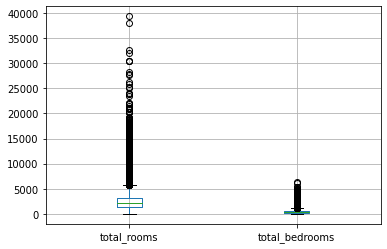

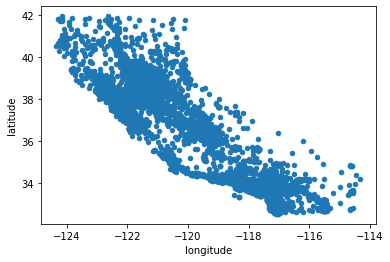

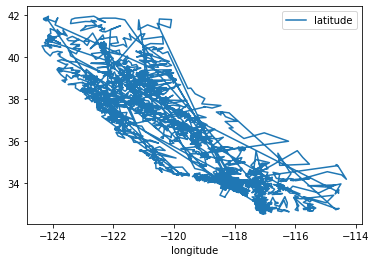

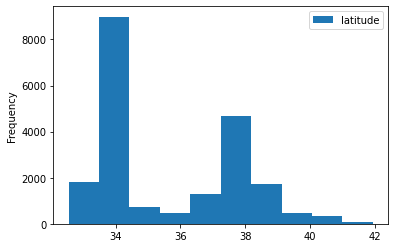

In [4]:
df.boxplot(column=['total_rooms','total_bedrooms'])
df.plot.scatter(x='longitude',y='latitude')
df.plot.line(x='longitude',y='latitude')
df.plot.hist(x='longitude',y='latitude')

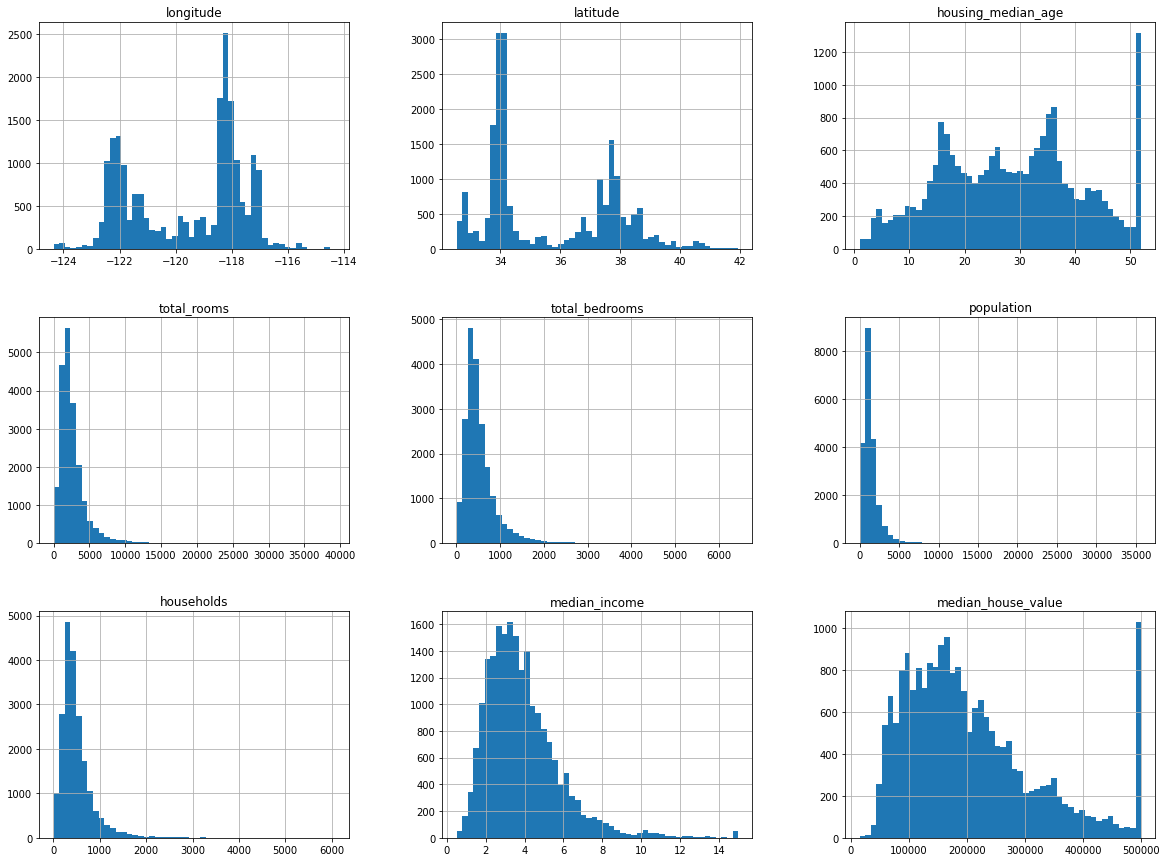

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

Recall: Machine learning algorithms perform better on Gaussian-like data distributions (also known as a bell curve). Observe features that are and are NOT Gaussian-like. 
- If data is Gaussian-like, use normalization: transforms data to values that sum to 1 using data min and max
- If data is not Gaussian-like, use standarization: transforms data to Gaussian distribution (looks like a bell curve) with values that sum to 1 using data mean and standard deviation

### Explore correlations

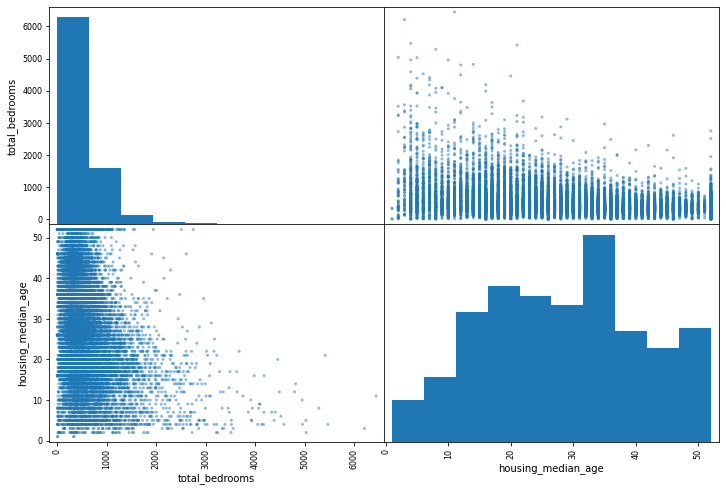

In [6]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

features = ['total_bedrooms','housing_median_age']
fig = scatter_matrix(df[features], figsize=(12, 8))
plt.show(fig[0][0].get_figure())

State the correlation magnitude and direction

In [7]:
correlation = df[features].corr()

In [8]:
from itertools import combinations

cor_summary_statements=[]
feature_pairs = combinations(features, 2)
for f1, f2 in feature_pairs:
    cor = correlation[f1][f2]
    if(abs(cor) > 0.5):
        print('f1 and f2 are strongly correlation')
    else:
        print('f1 and f2 are weakly correlation')
        
    if(cor < 0):
        print('f1 and f2 are negativey correlation')
    else:
        print('f1 and f2 are positively correlation')

f1 and f2 are weakly correlation
f1 and f2 are negativey correlation


# Preprocess Dataset

### View data with missing values or invalid inputs

In [9]:
# Used for top categories with missing data
top_n=3
missing_column_counts = df[df.columns[df.isnull().any()]].isnull().sum()
max_idxs = np.argsort(missing_column_counts.to_numpy())[::-1][:top_n]

# Compute missing statistics
num_categories = df.isna().any(axis=0).sum()
average_per_category = df.isna().sum().sum()/len(df.columns)
total_missing_values = df.isna().sum().sum()
top_missing_categories = df.columns[max_idxs[:top_n]].to_numpy()
    
print('Number of categories with missing values: {0:.2f}'.format(num_categories))
print('Average number of missing values per category: {0:.2f}'.format(average_per_category))
print('Total number of missing values: {0:.2f}'.format(total_missing_values))
print('Top {} categories with most missing values: {}'.format(top_n, top_missing_categories))

Number of categories with missing values: 10.00
Average number of missing values per category: 33.00
Total number of missing values: 330.00
Top 3 categories with most missing values: ['total_bedrooms' 'ocean_proximity' 'latitude']


### Remove irrelevant / useless features:

In [10]:
print(df.head())
remove_feature = ['households']
df.drop(remove_feature, axis=1)

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0             NaN  


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,3.8462,342200.0,NaN
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,1.8672,84700.0,INLAND


### Remove NaN rows

In [11]:
df.dropna(inplace=True)

In [12]:
# View updates to dataset
print(df.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
6    -122.25     37.84                52.0       2535.0           489.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
6      1094.0       514.0         3.6591            299200.0        NEAR BAY  


### Remove Outliers

array([[<AxesSubplot:title={'center':'median_income'}>]], dtype=object)

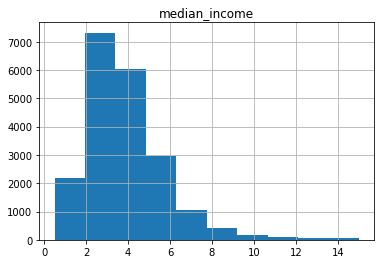

In [13]:
# Visualize data features
df.hist('median_income')

The upper bound is 8.012424999999999
The lower bound is -0.7031749999999994
The number of outlier removed is 668


array([[<AxesSubplot:title={'center':'median_income'}>]], dtype=object)

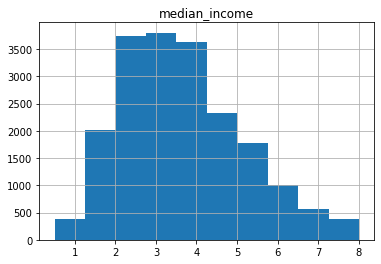

In [14]:
# Remove outliers
feature = 'median_income'

count = len(df)
lower_bound=None
upper_bound=None
if(feature in df.columns):
    Q1 = np.percentile(df[feature], 25, axis=0)
    Q3 = np.percentile(df[feature], 75, axis=0)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    df = df[df[feature]>lower_bound]
    df = df[df[feature]<upper_bound]
count = count - len(df)
print('The upper bound is {}'.format(upper_bound))
print('The lower bound is {}'.format(lower_bound))
print('The number of outlier removed is {}'.format(count))
df.hist('median_income')

### Handling Text and Categorical Attributes

Let's preprocess categorical data starting with Integer encoding transforms categorical data to integers

In [15]:
from sklearn.preprocessing import OrdinalEncoder

df_ = df.copy()
print(df_['ocean_proximity']) # before encoding
enc = OrdinalEncoder()
df_[['ocean_proximity']] = enc.fit_transform(df_[['ocean_proximity']])
print(df_['ocean_proximity']) # after encoding

2        NEAR BAY
3        NEAR BAY
6        NEAR BAY
7        NEAR BAY
8        NEAR BAY
           ...   
20635      INLAND
20636      INLAND
20637      INLAND
20638      INLAND
20639      INLAND
Name: ocean_proximity, Length: 19664, dtype: object
2        3.0
3        3.0
6        3.0
7        3.0
8        3.0
        ... 
20635    1.0
20636    1.0
20637    1.0
20638    1.0
20639    1.0
Name: ocean_proximity, Length: 19664, dtype: float64


One-hot encoding transforms categorical data to n bits where a unique bit is set to 1 for each category

In [16]:
print(df.head())
df = pd.get_dummies(df, columns = ['ocean_proximity']) # one-hot encoding
# View updates to dataset
print(df.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
6    -122.25     37.84                52.0       2535.0           489.0   
7    -122.25     37.84                52.0       3104.0           687.0   
8    -122.26     37.84                42.0       2555.0           665.0   

   population  households  median_income  median_house_value ocean_proximity  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
6      1094.0       514.0         3.6591            299200.0        NEAR BAY  
7      1157.0       647.0         3.1200            241400.0        NEAR BAY  
8      1206.0       595.0         2.0804            226700.0        NEAR BAY  
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \


# Create some new features

Although we often think of multiple regression as including multiple different features (e.g. # of bedrooms, squarefeet, and # of bathrooms) but we can also consider transformations of existing features e.g. the log of the squarefeet or even "interaction" features such as the product of bedrooms and bathrooms.

You will use the logarithm function to create a new feature. so first you should import it from the math library.

Next create the following new features as column in both TEST and TRAIN data:
* total_rooms_squared = total_rooms\*total_rooms
* age_bath_rooms = housing_median_age\*total_bedrooms
As an example here's the first two:

In [17]:
# bedrooms_squared = bedrooms*bedrooms
df['total_rooms_squared'] = df['total_rooms'].apply(lambda x:x**2)

# age_bathrooms = housing_age_bedrooms
def multiply_data(value_1, value_2):
    return value_1 * value_2

df['age_bath_rooms'] = df.apply(lambda x: multiply_data(x['housing_median_age'],x['total_bedrooms']),axis=1)

Create the following new features:
* log_population = log(population)
* lat_plus_long = lat + long 
* rooms_per_household = total_rooms/households
* number_bedrooms = total_bedrooms/households
* number_bathrooms = rooms_per_household - number_bedrooms
* bedrooms_per_room = total_bedrooms/total_rooms
* population_per_household = population/households
* age_rooms_per_household = housing_median_age*rooms_per_household

In [18]:
# Activity 
# [Ans]
df['log_population'] = df['population'].apply(lambda x: np.log(x))

def add_data(value_1, value_2):
    return value_1 + value_2

df['lat_plus_long'] = df.apply(lambda x: multiply_data(x['longitude'],x['latitude']),axis=1)
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["number_bedrooms"] = (df["total_bedrooms"]/df["households"]).apply(np.ceil)
df["number_bathrooms"] = (df["rooms_per_household"] - df["number_bedrooms"]).apply(np.ceil)
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"]=df["population"]/df["households"]
df['age_rooms_per_household' ] = multiply_data(df['housing_median_age'],df['rooms_per_household'])
print(df.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
6    -122.25     37.84                52.0       2535.0           489.0   
7    -122.25     37.84                52.0       3104.0           687.0   
8    -122.26     37.84                42.0       2555.0           665.0   

   population  households  median_income  median_house_value  \
2       496.0       177.0         7.2574            352100.0   
3       558.0       219.0         5.6431            341300.0   
6      1094.0       514.0         3.6591            299200.0   
7      1157.0       647.0         3.1200            241400.0   
8      1206.0       595.0         2.0804            226700.0   

   ocean_proximity_<1H OCEAN  ...  total_rooms_squared  age_bath_rooms  \
2                          0  ...            2152089.0          9880.0   
3               

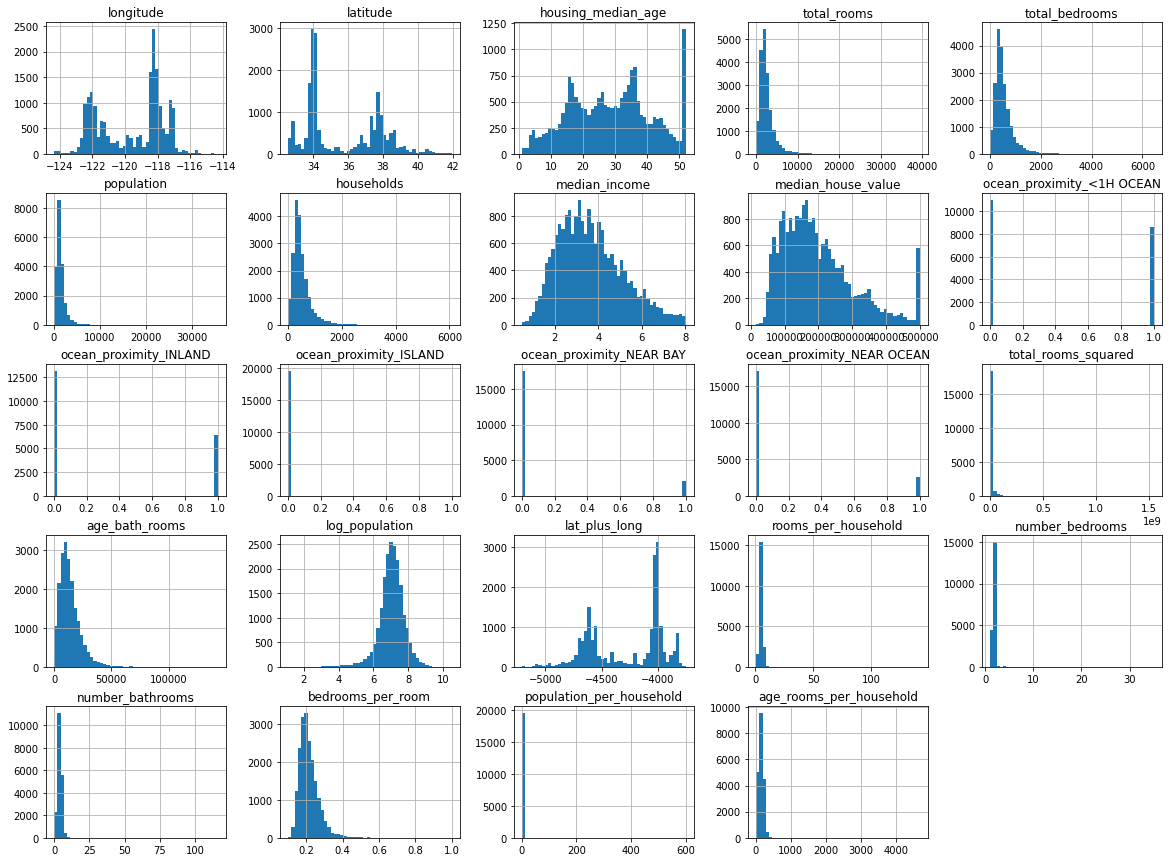

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

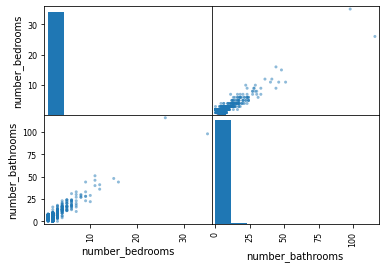

In [20]:
features = ['number_bedrooms','number_bathrooms']
fig = scatter_matrix(df[features], figsize=(6, 4))
plt.show(fig[0][0].get_figure())

Select input/output for regression

In [21]:
X, y = df.loc[:, ~df.columns.isin(['median_house_value'])], df.loc[:, df.columns.isin(['median_house_value'])]

Split data into train and test sets using train_test_split to randomly shuffle the data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13174, 23), (6490, 23), (13174, 1), (6490, 1))

# Training Regression Models

## Evaluation Metrics

Compute RMSA, MAE, and R2 on actual and predicted housing prices

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def print_info(mode, y_true, y_pred, print_results=True):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, squared=False))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if(print_results):
        print(mode + ": RMSE: {0}, MAE: {1}, R2: {2}".format(rmse,mae,r2))
    return rmse, mae, r2

Compute evaluation metrics on training and validation sets. Note: directly compute RMSE directly by calling the mean_squared_error() function with squared=False.

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)

from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X_train, y_train):
    train_rmse_errors, train_mae_errors, train_r2_errors = [], [], []
    val_rmse_errors, val_mae_errors, val_r2_errors = [], [], []
    for m in range(1, len(X_train) + 1, 15):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        
        train_rmse, train_mae, train_r2 = print_info("test", y_train[:m], y_train_predict, print_results=False)
        train_rmse_errors.append(train_rmse)
        train_mae_errors.append(train_mae)
        train_r2_errors.append(train_r2)
        
        val_rmse, val_mae, val_r2 = print_info("test", y_val, y_val_predict, print_results=False)
        val_rmse_errors.append(val_rmse)
        val_mae_errors.append(val_mae)
        val_r2_errors.append(val_r2)
    result = {'train_rmse_errors':train_rmse_errors, 
           'train_mae_errors':train_mae_errors, 
           'train_r2_errors':train_r2_errors, 
           'val_rmse_errors':val_rmse_errors, 
           'val_mae_errors':val_mae_errors, 
           'val_r2_errors':val_r2_errors}
    return result 

Plot learning curves on training and validation datasets

In [26]:
def plot_lc_figures(error1, error2, metric=''):
    plt.plot(error1, "r-+", linewidth=2, label="train")
    plt.plot(error2, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel(str(metric).upper(), fontsize=14)              # not shown

## Learning Single Models 

Train a simple liinear regression model using total_rooms to predict housing prices

In [27]:
from sklearn.linear_model import LinearRegression

single_reg_feature = ['total_rooms']
single_reg_model = LinearRegression()
single_reg_model.fit(X_train[single_reg_feature], y_train)

LinearRegression()

Now that you trained a model, evaluate the model on training data

In [28]:
single_reg_train_pred = single_reg_model.predict(X_train[single_reg_feature])
print_info("train", y_train, single_reg_train_pred)

train: RMSE: 324.99129701678186, MAE: 82765.42748545346, R2: 0.014880066489633581


(324.99129701678186, 82765.42748545346, 0.014880066489633581)

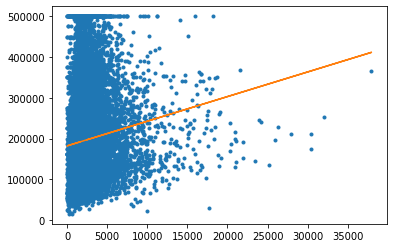

In [29]:
plt.plot(X_train[single_reg_feature], y_train, '.',
         X_train[single_reg_feature], single_reg_model.predict(X_train[single_reg_feature]), '-')

Now that you trained a model, evaluate the model on test data

In [30]:
single_reg_test_pred = single_reg_model.predict(X_test[single_reg_feature])
print_info("test", y_test, single_reg_test_pred)

test: RMSE: 326.6515773191335, MAE: 83624.74887433276, R2: 0.020113176734332883


(326.6515773191335, 83624.74887433276, 0.020113176734332883)

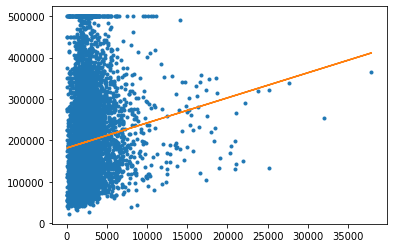

In [31]:
plt.plot(X_test[single_reg_feature], y_test, '.',
         X_test[single_reg_feature], single_reg_model.predict(X_test[single_reg_feature]), '-')

Now that we have fitted the model we can inspect the regression weights (coefficients) as follows:

In [32]:
# Inspect coefficients
print(single_reg_model.coef_)
print(single_reg_model.intercept_)

[[6.04839206]]
[181939.40300451]


## Learning Multiple Models 

Now that you have the features, learn the weights for the three different models for predicting median_house_value using multiple regression, test the model, and look at the value of the weights/coefficients:

In [33]:
multiple_reg_features = ['total_rooms','rooms_per_household']
multiple_reg_model = LinearRegression().fit(X_train[multiple_reg_features], y_train)

Now that you have trained the model, let's explore model performance on the training data.

In [34]:
multiple_reg_train_pred = multiple_reg_model.predict(X_train[multiple_reg_features])
print_info("train", y_train, multiple_reg_train_pred)

train: RMSE: 324.60560663308235, MAE: 82472.30534746051, R2: 0.01954819699788246


(324.60560663308235, 82472.30534746051, 0.01954819699788246)

Now that you have evaluated the model on the training data, let's explore how the model generalizes to new examples.

In [35]:
multiple_reg_test_pred = multiple_reg_model.predict(X_test[multiple_reg_features])
print_info("test", y_test, multiple_reg_test_pred)

test: RMSE: 326.3510104627609, MAE: 83358.67521500298, R2: 0.02371475429292469


(326.3510104627609, 83358.67521500298, 0.02371475429292469)

Now that we have fitted the model we can extract the regression weights (coefficients) as follows:

In [36]:
# Inspect coefficients
print(multiple_reg_model.coef_)
print(multiple_reg_model.intercept_)

[[   5.63922531 2746.91053454]]
[168240.2474238]


/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


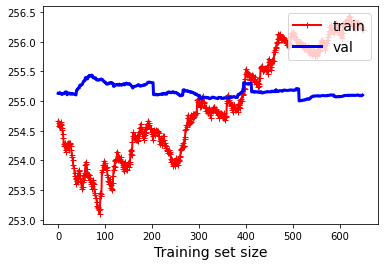

In [37]:
errors  = plot_learning_curves(multiple_reg_model, X_train, y_train)
#plot_lc_figures(errors['train_rmse_errors'], errors['val_rmse_errors'], metric='')
plot_lc_figures(errors['train_rmse_errors'][400:], errors['val_rmse_errors'][400:], metric='') # zoom in

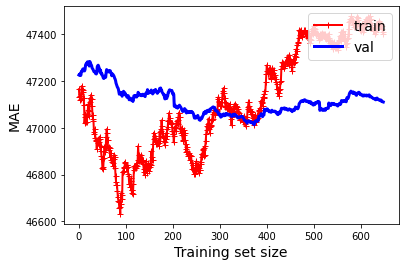

In [38]:
plot_lc_figures(errors['train_mae_errors'][400:], errors['val_mae_errors'][400:], metric='MAE')

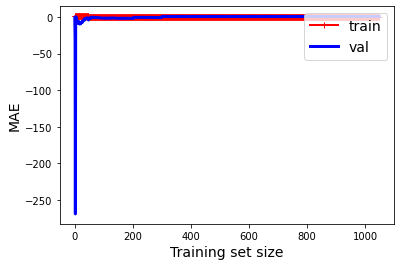

In [39]:
plot_lc_figures(errors['train_r2_errors'], errors['val_r2_errors'], metric='MAE')

# Learning Multiple Models

Now we will learn the weights for three (nested) models for predicting house prices. The first model will have the fewest features the second model will add one more feature and the third will add a few more:
* Model 1: 'total_rooms_squared', 'rooms_per_household', 'latitude', 'longitude'
* Model 2: add 'age_rooms_per_household', 'log_population'
* Model 3: Add 'median_income', 'lat_plus_long','bedrooms_per_room','population_per_household'

In [40]:
model_1_features = ['total_rooms_squared', 'rooms_per_household', 'latitude', 'longitude']
model_2_features = model_1_features + ['age_rooms_per_household', 'log_population']
model_3_features = model_2_features + ['median_income', 'lat_plus_long','bedrooms_per_room','population_per_household']

Notes: 
* Squaring rooms_per_household will increase the separation between not many rooms (e.g. 1) and lots of rooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this feature will mostly affect houses with many rooms per household.
* House age times rooms_per_household gives what's called an "interaction" feature. It is large when *both* of them are large.
* Taking the log of population has the effect of bringing large values closer together and spreading out small values.
* Adding latitude to longitude is totally non-sensical but we will do it anyway (you'll see why)

In [41]:
# Activity: Fit three models
multiple_reg_model1 = LinearRegression().fit(X_train[model_1_features], y_train)
multiple_reg_model2 = LinearRegression().fit(X_train[model_2_features], y_train)
multiple_reg_model3 = LinearRegression().fit(X_train[model_3_features], y_train)

In [42]:
# Activity: Evaluate models
multiple_reg_train_pred1 = multiple_reg_model1.predict(X_train[model_1_features])
multiple_reg_train_pred2 = multiple_reg_model2.predict(X_train[model_2_features])
multiple_reg_train_pred3 = multiple_reg_model3.predict(X_train[model_3_features])

In [43]:
# Activity: Examine/extract each model's coefficients
print("Model 1 coefficients: {}".format(multiple_reg_model1.coef_))
print("Model 2 coefficients: {}".format(multiple_reg_model2.coef_))
print("Model 3 coefficients: {}".format(multiple_reg_model3.coef_))

**Discussion Question: What is the sign (positive or negative) for the coefficient/weight for 'rooms_per_household' in model 1?**

**Discussion Question: What is the sign (positive or negative) for the coefficient/weight for 'rooms_per_household' in model 2?**

Think about what this means.

Use your functions from earlier to compute the RMSE, MAE, and R2 score on TRAINING Data for each of the three models.

In [44]:
# Activity: Evaluate models on training data
print_info("train model 1", y_train, multiple_reg_train_pred1)
print_info("train model 2", y_train, multiple_reg_train_pred2)
print_info("train model 3", y_train, multiple_reg_train_pred3)

**Discussion Question: Which model (1, 2 or 3) has lowest RMSE, MAE, and R2 score  on TRAINING Data?** Is this what you expected?

Now compute the RMSE, MAE, and R2 on on TEST data for each of the three models.

In [45]:
# Activity: Evaluate models on test data
multiple_reg_test_pred1 = multiple_reg_model1.predict(X_test[model_1_features])
multiple_reg_test_pred2 = multiple_reg_model2.predict(X_test[model_2_features])
multiple_reg_test_pred3 = multiple_reg_model3.predict(X_test[model_3_features])

print_info("test model 1", y_test, multiple_reg_test_pred1)
print_info("test model 2", y_test, multiple_reg_test_pred2)
print_info("test model 3", y_test, multiple_reg_test_pred3)

**Discusson Question: Which model (1, 2 or 3) has lowest RMSE, MAE, and R2 on TESTING Data?** Is this what you expected? Think about the features that were added to each model from the previous.

## Learning Polynomial Models 

In [92]:
from sklearn.preprocessing import PolynomialFeatures

There are two options for training regression models. 
- Option 1: Step by step: normalize or standardize features, compute the squared polynomial on the features
- Option 2: Use a Transformation pipeline to perform Option 1 in one step

In [94]:
# Option 1

# Scale features between 0 and 1
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)

# Create polynomial features --> features^2
poly_features = PolynomialFeatures(degree=3, include_bias=False)

# Transform scaled, polynomial features
X_poly_train = poly_features.fit_transform(X_train_scaler)
X_poly_test = poly_features.transform(X_test_scaler)

# Fit the model to data
poly_reg_model = LinearRegression().fit(X_poly_train, y_train)

In [95]:
# Option 2

'''poly_reg_model = Pipeline([('scaler', StandardScaler()), 
                           ('poly', PolynomialFeatures(degree=3, include_bias=False)), 
                           ('polyReg', LinearRegression())])
poly_reg_model.fit(X_train, y_train)'''

"poly_reg_model = Pipeline([('scaler', StandardScaler()), \n                           ('poly', PolynomialFeatures(degree=3, include_bias=False)), \n                           ('polyReg', LinearRegression())])\npoly_reg_model.fit(X_train, y_train)"

Now that you have the features, learn the weights for the three different models for predicting median_house_value using polynomial regression, test the model, and look at the value of the weights/coefficients:

In [96]:
poly_reg_train_pred = poly_reg_model.predict(X_poly_train)
print_info("train", y_train, poly_reg_train_pred)

train: RMSE: 213.7609268107234, MAE: 31815.61165853122, R2: 0.8156192922700402


(213.7609268107234, 31815.61165853122, 0.8156192922700402)

Now that you have evlauated the model on the training data, let's explore how the model generalizes to new examples.

In [97]:
poly_reg_test_pred = poly_reg_model.predict(X_poly_test)
print_info("test", y_test, poly_reg_test_pred)

test: RMSE: 6657.241050086078, MAE: 5985780.615365442, R2: -169048.54611257702


(6657.241050086078, 5985780.615365442, -169048.54611257702)

Now that we have fitted the model we can extract the regression weights (coefficients) as follows:

In [98]:
# Inspect coefficients
print(poly_reg_model.coef_)
print(poly_reg_model.intercept_)

[[1282485.17039243 -300728.97385061 -529641.36905354 ...  467349.62610058
  -437557.51409102   -3435.85351856]]
[6109129.33304713]


In [99]:
errors = plot_learning_curves(poly_reg_model, X_train, y_train)

/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


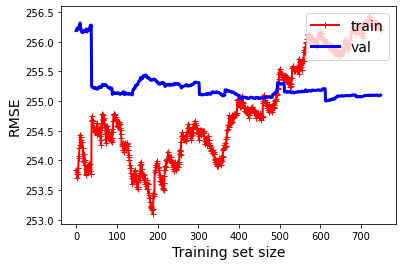

In [53]:
plot_lc_figures(errors['train_rmse_errors'][300:], errors['val_rmse_errors'][300:], metric='RMSE')

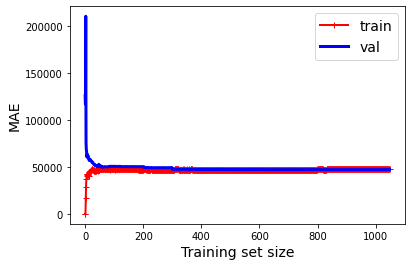

In [54]:
plot_lc_figures(errors['train_mae_errors'], errors['val_mae_errors'], metric='MAE')

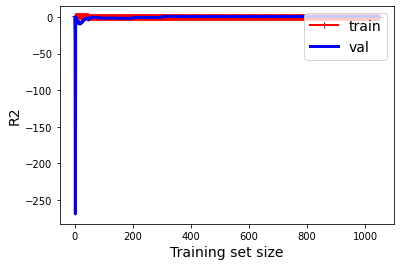

In [55]:
plot_lc_figures(errors['train_r2_errors'], errors['val_r2_errors'], metric='R2')

Next, write a loop that does the following:
* For degree in [1, 2, 3, 4])
    * Create a series of features with increasing degree of polynomial x^1, x^2 what x is the 
    * Train a polynomial regression model
    * Learn a polynomial regression model to total_rooms vs price with that degree on TRAIN data

In [56]:
# Activity 
# Option 1: Poly Features -> Linear Regression
num_degrees=4
for degree_ in range(1,num_degrees):
    print('Degree {} of {} complete'.format(degree_,num_degrees))
    scaler = StandardScaler()
    X_train_scaler = scaler.fit_transform(X_train)
    X_test_scaler = scaler.fit_transform(X_test)
    
    poly_features = PolynomialFeatures(degree=degree_, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train_scaler)
    X_poly_test = poly_features.transform(X_test_scaler)
    poly_reg_model = LinearRegression().fit(X_poly_train, y_train)
    
    poly_reg_train_pred = poly_reg_model.predict(X_poly_train)
    print_info("train", y_train, poly_reg_train_pred)

In [57]:
# Activity 
# Option 2: Transformation pipeline
for degree_ in range(1,num_degrees):
    print('Degree {} of {} complete'.format(degree_,num_degrees))
    poly_reg_model = Pipeline([('scaler', StandardScaler()), 
                           ('poly', PolynomialFeatures(degree=degree_, include_bias=False)), 
                           ('polyReg', LinearRegression())])
    poly_reg_model.fit(X_train, y_train)
    
    poly_reg_train_pred = poly_reg_model.predict(X_train)
    print_info("train", y_train, poly_reg_train_pred)

* Report which degree had the lowest RMSE, MAE, R2 on validation data

# Learning Ridge Regression Models

Recall that ridge regression model solves uses a loss function with a linear least squares function and regularization is given by the l2-norm. Its useful for shrinking model coefficients for features that are not useful for model prediction. 

In [58]:
from sklearn.linear_model import Ridge

Use closed form solution to compute ridge coefficients, solver="cholesky"

In [59]:
ridge_model = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_model.fit(X_train, y_train)
ridge_reg_train_pred = ridge_model.predict(X_train)
print_info("train", y_train, ridge_reg_train_pred)

train: RMSE: 256.2558893166127, MAE: 47438.54126861811, R2: 0.6191994181156103


/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.31956e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


(256.2558893166127, 47438.54126861811, 0.6191994181156103)

In [100]:
# Inspect coefficents
print('The ridge coefficients of cholesky is: {}'.format(ridge_model.coef_))
print('The ridge intercept of cholesky is: {}'.format(ridge_model.intercept_))

The ridge coefficients of cholesky is: [[-9.46263719e+04  2.23867103e+05 -2.43734460e+01  9.42390383e+00
  -3.94772035e+00 -2.81022047e+01  5.83713233e+01  4.53435559e+04
  -1.69440764e+04 -5.61532875e+04  9.88235993e+04 -1.93679286e+04
  -6.35830678e+03 -1.94379741e-04  2.17452921e+00 -2.59449242e+04
   2.03763800e+03 -1.49224443e+03  7.44852036e+03 -7.38077299e+02
   2.57308654e+05  8.69857916e+01  4.14831946e+01]]
The ridge intercept of cholesky is: [-10461167.04657301]


Use least squares solution to compute ridge coefficients, solver="lsqr". Observe the change in performance. Does it go down or up?

In [102]:
ridge_model = Ridge(alpha=1, solver="lsqr", random_state=42)
ridge_model.fit(X_train, y_train)
ridge_reg_train_pred = ridge_model.predict(X_train)
print_info("train", y_train, ridge_reg_train_pred)

train: RMSE: 325.9251253297794, MAE: 83528.04531488096, R2: 0.0035086175865176594


(325.9251253297794, 83528.04531488096, 0.0035086175865176594)

In [103]:
# Inspect coefficents
print('The ridge coefficients of lsqr is: {}'.format(ridge_model.coef_))
print('The ridge intercept of lsqr is: {}'.format(ridge_model.intercept_))

The ridge coefficients of lsqr is: [[-8.42720530e-12 -2.84561386e-11  1.30815884e-10  2.33968122e-08
   2.68539254e-09 -1.64242776e-09  2.91981578e-09  8.24662843e-11
   1.17119347e-11 -2.08041262e-11  3.71777426e-14  4.60003984e-12
   4.45497391e-12  1.82668538e-04  1.45308931e-07 -3.67693162e-13
   3.13202921e-09  1.96468965e-11 -1.67752873e-12  2.14527419e-11
  -8.96423864e-13 -2.45299634e-11  1.30140657e-09]]
The ridge intercept of lsqr is: [195685.9941111]


### Cross Validation for regularization parameter search 

### Cross validation option 1

In [104]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
#from numpy import absolute

Define lasso hyperparameters

In [106]:
n_splits=5
n_repeats=3
scoring='neg_mean_absolute_error' # neg_mean_squared_error for RMSE, 'r2' for R2 score

# evaluation method
ridge_cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)

In [107]:
# define model
ridge_model = Ridge(alpha=1.0)

# evaluate model
scores = cross_val_score(ridge_model, X_train, y_train, scoring=scoring, cv=ridge_cv, n_jobs=-1)

# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# fit model
ridge_model.fit(X_train, y_train)
ridge_reg_train_pred = ridge_model.predict(X_train)
print_info("train", y_train, ridge_reg_train_pred)

Mean MAE: 47584.518 (560.716)
train: RMSE: 256.2558893166127, MAE: 47438.54126861811, R2: 0.6191994181156103


/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.31956e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


(256.2558893166127, 47438.54126861811, 0.6191994181156103)

In [108]:
# Inspect coefficents
print('The ridge coefficients are: {}'.format(ridge_model.coef_))
print('The ridge intercept is: {}'.format(ridge_model.intercept_))

The ridge coefficients are: [[-9.46263719e+04  2.23867103e+05 -2.43734460e+01  9.42390383e+00
  -3.94772035e+00 -2.81022047e+01  5.83713233e+01  4.53435559e+04
  -1.69440764e+04 -5.61532875e+04  9.88235993e+04 -1.93679286e+04
  -6.35830678e+03 -1.94379741e-04  2.17452921e+00 -2.59449242e+04
   2.03763800e+03 -1.49224443e+03  7.44852036e+03 -7.38077299e+02
   2.57308654e+05  8.69857916e+01  4.14831946e+01]]
The ridge intercept is: [-10461167.04657301]


### Cross validation option 2 - Parameter search

In [67]:
from sklearn.model_selection import GridSearchCV

Set ridge parameters:
- alpha: controls regularization strength. Decide how much to penalize feature weights
- solver: method used for solving for regularization parameter

In [109]:
ridge_params = {
  'alpha': [1, 0.5, 0.1], #[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
  'solver': ['cholesky', 'sag']
}

Train a ridge regression model with l2 norm regularization.

In [110]:
ridge_cv_grid = GridSearchCV(estimator=Ridge(), 
                        param_grid=ridge_params, 
                        cv=ridge_cv)
ridge_cv_grid.fit(X_train, y_train)

/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.85926e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.95344e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.82797e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.96753e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/lin

/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/angeliquetaylor/opt/anaconda3/lib/pyt

/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/angeliquetaylor/opt/anaconda3/lib/pyt

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Ridge(),
             param_grid={'alpha': [1, 0.5, 0.1], 'solver': ['cholesky', 'sag']})

Now, evaluate the model on the training data

In [111]:
ridge_reg_train_pred = ridge_cv_grid.predict(X_train)
print_info("train", y_train, ridge_reg_train_pred)

train: RMSE: 256.2454636060876, MAE: 47429.141188310336, R2: 0.6192613854618718


(256.2454636060876, 47429.141188310336, 0.6192613854618718)

Now, evaluate the model on the test data

In [114]:
ridge_reg_test_pred = ridge_cv_grid.predict(X_test)
print_info("test", y_test, ridge_reg_test_pred)

test: RMSE: 257.5470050505582, MAE: 47356.775729241504, R2: 0.6213282602858763


(257.5470050505582, 47356.775729241504, 0.6213282602858763)

In [115]:
# Inspect cross validation performance, optimal score and parameters
print('Best model acheived a score: %s'% ridge_cv_grid.best_score_)
print('Best model parameters: %s' % ridge_cv_grid.best_params_)

Best model acheived a score: 0.6144419283424916
Best model parameters: {'alpha': 0.5, 'solver': 'cholesky'}


### Cross validation option 3 - Parameter search using a tranformation pipeline

In [116]:
ridge_cv_pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('ridgeCV', GridSearchCV(estimator=Ridge(), 
                     param_grid=ridge_params, cv=ridge_cv))])

Fit the model to the data while regularizing the weights using l2 norm penalty

In [117]:
ridge_cv_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridgeCV',
                 GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
                              estimator=Ridge(),
                              param_grid={'alpha': [1, 0.5, 0.1],
                                          'solver': ['cholesky', 'sag']}))])

Now that you have the features, learn the weights for the three different models for predicting median_house_value using linear regression, test the model, and look at the value of the weights/coefficients:

In [118]:
ridge_reg_train_pred = ridge_cv_pipeline.predict(X_train)
print_info("train", y_train, ridge_reg_train_pred)

train: RMSE: 256.2524761327543, MAE: 47425.271048700866, R2: 0.6192197059058392


(256.2524761327543, 47425.271048700866, 0.6192197059058392)

Now that you have evlauated the model on the training data, let's explore how the model generalizes to new examples.

In [119]:
ridge_reg_test_pred = ridge_cv_pipeline.predict(X_test)
print_info("test", y_test, ridge_reg_test_pred)

test: RMSE: 257.55577958866076, MAE: 47350.43055311342, R2: 0.6212766527835486


(257.55577958866076, 47350.43055311342, 0.6212766527835486)

Inspect cross validation performance, optimal score and parameters
- mean_fit_time: mean time to fit the model
- mean_score_time: evaluate score
- params: alpha and solver parameters
- split0_test_score: evaluate score for each fold
- mean_test_score: average test score
- std_test_score: standard deviation of test score
- rank_test_score: rank of best to worst perfoming model from 1 to number of folds

### Find the *best* ridge regression  model

In [120]:
#print('Best model acheived a score: %s'% ridge_cv[-1].cv_results_)
print('Best model mean_fit_time: %s'% ridge_cv_pipeline[-1].cv_results_['mean_fit_time'])
print('Best model mean_score_time: %s'% ridge_cv_pipeline[-1].cv_results_['mean_score_time'])
print('Best model params: %s'% ridge_cv_pipeline[-1].cv_results_['params'])
print('Best model split0_test_score: %s'% ridge_cv_pipeline[-1].cv_results_['split0_test_score'])
print('Best model mean_test_score: %s'% ridge_cv_pipeline[-1].cv_results_['mean_test_score'])
print('Best model std_test_score: %s'% ridge_cv_pipeline[-1].cv_results_['std_test_score'])
print('Best model rank_test_score: %s'% ridge_cv_pipeline[-1].cv_results_['rank_test_score']) # top model with rank=1

Best model mean_fit_time: [0.00311672 0.27531214 0.00293509 0.27881834 0.00303451 0.2843152 ]
Best model mean_score_time: [0.00092975 0.00114333 0.00087326 0.00110076 0.00084933 0.00102703]
Best model params: [{'alpha': 1, 'solver': 'cholesky'}, {'alpha': 1, 'solver': 'sag'}, {'alpha': 0.5, 'solver': 'cholesky'}, {'alpha': 0.5, 'solver': 'sag'}, {'alpha': 0.1, 'solver': 'cholesky'}, {'alpha': 0.1, 'solver': 'sag'}]
Best model split0_test_score: [0.58555319 0.5854421  0.5860064  0.58540875 0.58649814 0.5853762 ]
Best model mean_test_score: [0.61304747 0.61168721 0.61361729 0.6116868  0.61430888 0.61168425]
Best model std_test_score: [0.01160441 0.01144872 0.01159278 0.0114543  0.01155941 0.01146095]
Best model rank_test_score: [3 4 2 5 1 6]


Next, train a ridge model using parameters for the best performing model from above. What are the ridge coefficients?

In [78]:
# Activity [Ans]

# Get solver and parameters of top model

# Normalize data

# Use parameters and solver for top model

# Evlauate model on training data

# Evlauate model on test data

## Learning Lasso Regression Models

In [121]:
from sklearn.linear_model import Lasso

In [122]:
lasso_model = Lasso(alpha=1, random_state=42)
lasso_model.fit(X_train, y_train)
lasso_reg_train_pred = lasso_model.predict(X_train)
print_info("train", y_train, lasso_reg_train_pred)

train: RMSE: 256.7130776280482, MAE: 47623.761694862944, R2: 0.616474578607032


/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34169206448132.695, tolerance: 17813700592.794914
  model = cd_fast.enet_coordinate_descent(


(256.7130776280482, 47623.761694862944, 0.616474578607032)

Define lasso hyperparameters

In [123]:
n_splits=5
n_repeats=3
scoring='neg_mean_absolute_error' # neg_mean_squared_error for RMSE, 'r2' for R2 score

# evaluation method
lasso_cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)

Define regularization parameter 
- alpha: (referred to as lambda in slides) weight used to determine most useful features for predecting housing prices; must be non-negative
- tolerance: determines when cross validation ends; set to low leads to early stopping and could result in bad performance; set too high could result in long training time for convergence.

In [124]:
lasso_params = {
  'tol': [1, 0.5, 0.1],
  'alpha': [1, 0.5, 0.1],
}

Perform cross validation to search for the best lambda paramater (alpha) using l1 norm regularization.

In [125]:
# Option 1
lasso_cv = GridSearchCV(estimator=Lasso(), param_grid=lasso_params, cv=lasso_cv).fit(X_train, y_train)

/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26901101767827.555, tolerance: 14240688242464.57
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27394289978126.8, tolerance: 14225954415247.838
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27545269397150.02, tolerance: 14276957989811.785
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/

/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27518074220031.234, tolerance: 14282753652546.54
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27231631774371.56, tolerance: 14239893962914.754
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27060089227462.29, tolerance: 14142080450053.797
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib

In [84]:
# Option 2: Transformation Pipelines
#lasso_cv = Pipeline([('scaler', StandardScaler()), ('lassoCV', GridSearchCV(estimator=Lasso(), param_grid=lasso_params, cv=lasso_cv))])

Fit the model to the data while regularizing the weights using l1 norm penalty, learn the weights for predicting median_house_value using lasso regression, test the model, and look at the value of the weights/coefficients:

In [85]:
lasso_cv.fit(X_train, y_train)

/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26901101767827.555, tolerance: 14240688242464.57
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27394289978126.8, tolerance: 14225954415247.838
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27545269397150.02, tolerance: 14276957989811.785
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/

/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27518074220031.234, tolerance: 14282753652546.54
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27231631774371.56, tolerance: 14239893962914.754
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27060089227462.29, tolerance: 14142080450053.797
  model = cd_fast.enet_coordinate_descent(
/Users/angeliquetaylor/opt/anaconda3/lib

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Lasso(),
             param_grid={'alpha': [1, 0.5, 0.1], 'tol': [1, 0.5, 0.1]})

In [126]:
# View params with best performance
lasso_cv.best_params_

{'alpha': 1, 'tol': 0.1}

Now, evaluate the model on the training data

In [127]:
lasso_reg_train_pred = lasso_cv.predict(X_train)
print_info("train", y_train, lasso_reg_train_pred)

train: RMSE: 256.7130776280482, MAE: 47623.761694862944, R2: 0.616474578607032


(256.7130776280482, 47623.761694862944, 0.616474578607032)

Now, evaluate the model on the test data

In [128]:
lasso_reg_test_pred = lasso_cv.predict(X_test)
print_info("test", y_test, lasso_reg_test_pred)

test: RMSE: 257.99076416358776, MAE: 47537.435980562455, R2: 0.6187116686187812


(257.99076416358776, 47537.435980562455, 0.6187116686187812)

Inspect cross validation performance, optimal score and parameters
- mean_fit_time: mean time to fit the model
- mean_score_time: evaluate score
- params: alpha and solver parameters
- split0_test_score: evaluate score for each fold
- mean_test_score: average test score
- std_test_score: standard deviation of test score
- rank_test_score: rank of best to worst perfoming model from 1 to number of folds

In [89]:
#print('Best model acheived a score: %s'% lasso_cv.cv_results_.keys())
print('Best model mean_test_score: %s'% lasso_cv.cv_results_['mean_test_score'])
print('Best model rank_test_score: %s'% lasso_cv.cv_results_['rank_test_score'])

Best model mean_test_score: [0.59586267 0.59586267 0.61162391 0.59586458 0.59586458 0.61162066
 0.59586589 0.59586589 0.61161846]
Best model rank_test_score: [8 8 1 6 6 2 4 4 3]


Next, 
- Use cross validation to learn l1 norm regularization weights for lasso regression
- Use the best model parameters to train a lasso regression model
- Evaluate the lasso model using RMSE, MAE, and R2 
(see ridge regression example)

In [131]:
# Activity 
rank_test_score = lasso_cv.cv_results_['rank_test_score']
top_model_idx = np.argmin(rank_test_score)
top_model_param = lasso_cv.cv_results_['params'][top_model_idx]
top_alpha = top_model_param['alpha']
top_tol = top_model_param['tol']
print('The top model has alpha: {} and tolerance: {}'.format(top_alpha,top_tol))

The top model has alpha: 1 and tolerance: 0.1


In [132]:
# Create a lasso model with parameters of the best model
lasso_model = Lasso(alpha=top_alpha, tol=top_tol, random_state=42)
# Train lasso model
lasso_model.fit(X_train, y_train)
# Predict housing prices on training data
lasso_reg_train_pred = lasso_model.predict(X_train)
# Evaluate model on training data
print_info("train", y_train, lasso_reg_train_pred)
# Predict housing prices on test data
lasso_reg_test_pred = lasso_model.predict(X_test)
# Evaluate model on training data
print_info("test", y_test, lasso_reg_test_pred)

train: RMSE: 256.7130776280482, MAE: 47623.761694862944, R2: 0.616474578607032
test: RMSE: 257.99076416358776, MAE: 47537.435980562455, R2: 0.6187116686187812


/Users/angeliquetaylor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34169206448132.695, tolerance: 17813700592794.914
  model = cd_fast.enet_coordinate_descent(


(257.99076416358776, 47537.435980562455, 0.6187116686187812)

Test multiple regression model on one example

In [129]:
multiple_reg_features = ['number_bedrooms','number_bathrooms']
multiple_reg_model = LinearRegression().fit(X_train[multiple_reg_features], y_train)

multiple_reg_train_pred = multiple_reg_model.predict(X_train[multiple_reg_features])
print_info("train", y_train, multiple_reg_train_pred)

train: RMSE: 324.50857155423654, MAE: 82398.78080558908, R2: 0.02072002600818501


(324.50857155423654, 82398.78080558908, 0.02072002600818501)

In [130]:
example_house = [2,2]
multiple_reg_train_pred = multiple_reg_model.predict([example_house])
print('multiple_reg_train_pred: {}'.format(multiple_reg_train_pred))

multiple_reg_train_pred: [[178273.0981794]]
